# GAP Reconstruction

Reconstructing timestamp using the logfile. We identify the regions of interest, and the UTC times they occur in and then proceed with plugging them back to the data and fixing the time. In particular we are focused on the gaps in the rate when the threshold is zero

In [1]:
# import necessary modules
import matplotlib.pyplot as plt
import raadpy as rp
import numpy as np
import os

# Define some constants
# raw_dir = '../../Data/RAW/'
SD      = '2022-09-19' 
raw_dir = '../../Data/Light-1/light1-'+SD+'/'

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]
for name in fnames: 
    if 'log' in name: filenames['log'] = name

print(filenames)

%matplotlib widget

{'buff1': 'light1-SD-1651-buff1.dat', 'buff2': 'light1-SD-1651-buff2.dat', 'buff3': 'light1-SD-1651-buff3.dat', 'buff4': 'light1-SD-1651-buff4.dat', 'buff5': 'light1-SD-1651-buff5.dat', 'buff6': 'light1-SD-1651-buff6.dat', 'buff7': 'light1-SD-1651-buff7.dat', 'buff8': 'light1-SD-1651-buff8.dat', 'log': 'light1-SD-1651-se-log.txt'}


In [2]:
# Directory of the buffer
# buffer_fname    = raw_dir + SD + '/light1-'+SD+'-buff1.dat'
# Or:
buffer_fname    = raw_dir + filenames['buff1']

# Decode the buffer data in a dictionary
data_SiPM   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 1")
data_PMT    = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 0")

Line:   0%|          | 0/19392 [00:00<?, ?it/s]

Line:   0%|          | 0/19392 [00:00<?, ?it/s]

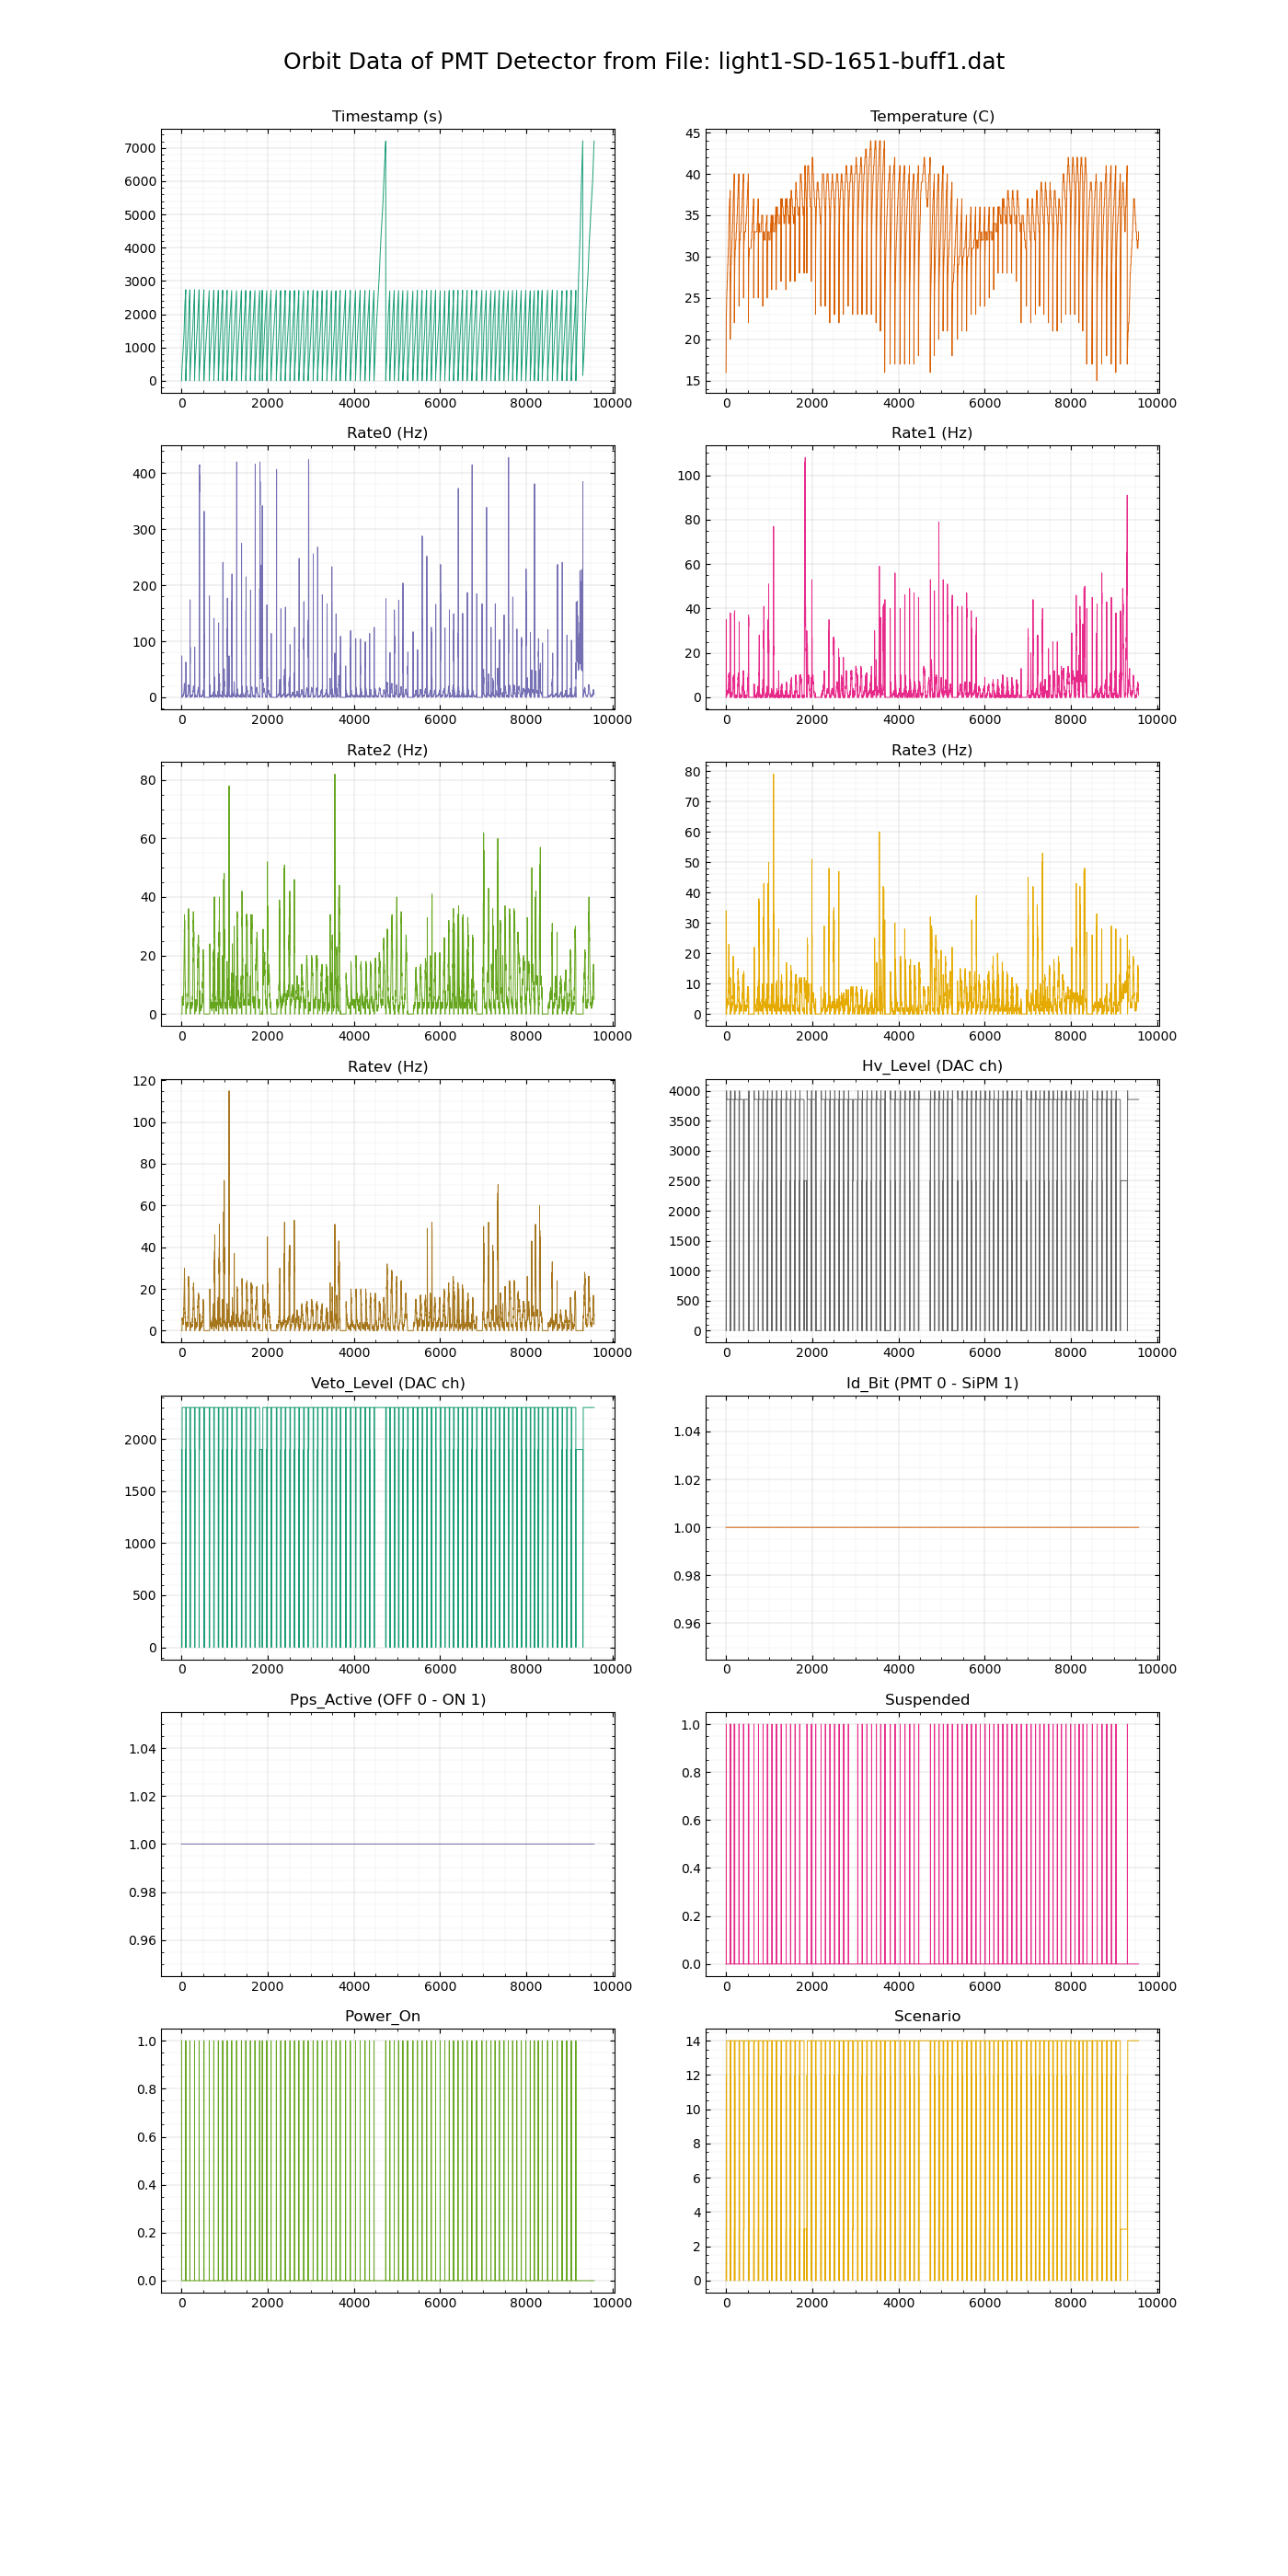

In [6]:
# Now print the PMT Data
fig, axes  = rp.plot_buffer(data_SiPM,title = 'Orbit Data of PMT Detector from File: '+ filenames['buff1'],UNITS=rp.ORBIT_UNITS)

In [7]:
# Now we load the log file and find it's timestamps
log     = rp.log_expand(filename=raw_dir+filenames['log'])      # Load the logfile
log     = rp.log_with_timestamp(log)                            # Find the timestamp each command finished executing
data    = data_SiPM.copy()

# Now we want to get only the commands that set the thresholds of all the payloads to their max
sc_commands = []
PAYLOAD     = rp.SIPM
CMD         = f"csp txrx {PAYLOAD} 9 3000 00000009FFFFFFFFFFFFFFFF"
IGNORE_FAIL = True
for line in log:
    # If This is the correct command
    if CMD in line['command']:
        # If it was executed correctly
        if IGNORE_FAIL or 'OK\n' in line['output']:
            # Append this to the high voltage commands
            sc_commands.append(line)

# Now we can see the times when the thresholds were maximized
time     = np.array([cmd['timestamp']    for cmd in sc_commands])

Found weird command
 {'command': 'SE0>rtc read\n', 'output': ['curr rtc time 16657438script delayuntil 1665756900\n', 'OK\n']}
Found weird command
 {'command': 'SE0>script delay 18script delayuntil 1666075500\n', 'output': ['OK\n']}


In [23]:
# Finding the event numbers when the rate goes to zero
# We look at the HV plot and see when that drops to zero
def trim(array):
    idx = np.where(array[1:] - array[:-1] != 0)[0] 
    return array[idx].astype(int), idx

hv_trim, hv_idx = trim(data['hv_level'][np.where(data['hv_level'] < 1)])
hv_idx_diff     = hv_idx[1:] - hv_idx[:-1]

# plt.figure()
# plt.hist(hv_idx_diff,bins=60)

print(hv_trim)


[]
